In [2]:
import torch
from torchvision import transforms
import yaml
from Pneumonia_predictor import PneumoniaDataset, PneumoniaPredictorCNN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.tensorboard.writer import SummaryWriter
from datetime import datetime
import logging
from helper_funcs import init_writer
from Trainer import Trainer
from pathlib import Path
from torchsummary import summary


In [3]:
logging.basicConfig(level=logging.INFO)

# Load the configuration file
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

seed = config["seed"]
torch.manual_seed(seed)
np.random.seed(seed)

model_output_dir = Path(config["model_output_dir"])
model_output_dir.mkdir(parents=True, exist_ok=True)


In [4]:
# load data
train_data_df = pd.read_csv(f'{config["data_dir"]}/train_data.csv')
val_data_df = pd.read_csv(f'{config["data_dir"]}/val_data.csv')
test_data_df = pd.read_csv(f'{config["data_dir"]}/test_data.csv')
print(f"Train data shape: {train_data_df.shape} \nValidation data shape: {val_data_df.shape} \nTest data shape: {test_data_df.shape}")


Train data shape: (4185, 3) 
Validation data shape: (1047, 3) 
Test data shape: (624, 3)


In [5]:
image_size = config['image_size']
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [6]:
train_dataset = PneumoniaDataset(train_data_df, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers= config['num_workers'])

val_dataset = PneumoniaDataset(val_data_df, transform=val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers= config['num_workers'])

test_dataset = PneumoniaDataset(test_data_df, transform=val_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers= config['num_workers'])

batch image shape: torch.Size([32, 1, 224, 224])
batch label shape: torch.Size([32])


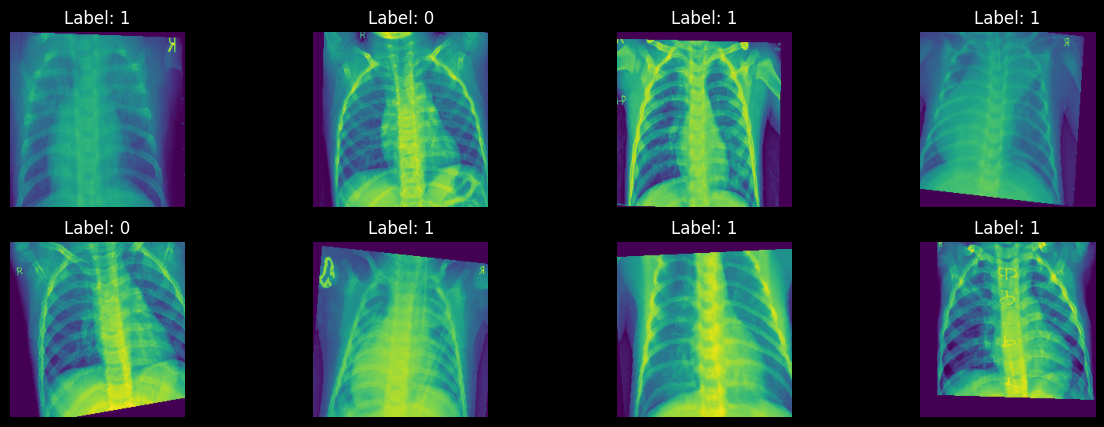

In [6]:
# Display a batch of images
def show_batch(images, labels):
    plt.figure(figsize=(15, 5))
    config = min(8, len(images))  # Limit to 8 images for display
    for i in range(config):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

# Quick test to see if the dataset and dataloader are working
images, labels = next(iter(train_loader))
print(f'batch image shape: {images.shape}')
print(f'batch label shape: {labels.shape}')

show_batch(images, labels)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

# load model parameters
model_params = {'image_size':config['image_size'],
                'in_channels':config['in_channels'], 
                'conv_defs':config['conv_layers'], 
                'fc_defs':config['fc_layers'],
                'fc_dropout':config['fc_dropout'],
                'fc_batch_norm':config['fc_batch_norm']
                }

model = PneumoniaPredictorCNN(**model_params)
model.to(device)




cpu_device = torch.device("cpu")  # or "cuda" if using GPU
model.to(cpu_device)
model.eval()
summary(model, (1, 224, 224), device="cpu")

model.to(device)
# load training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
loss_fn = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    mode='min',
                                                    factor=config['factor'],
                                                    patience=config['patience'],
                                                    cooldown=config['cooldown'],
                                                    min_lr=1e-7,
                                                    )



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [8]:

timestamp = datetime.now().strftime('%d_%m_%H%M%S')
model_identifier = (
        f"{config['model_name']}"
        f"_bs{config['batch_size']}"
        f"_lr{config['learning_rate']}"
        f"_epoch{config['epochs']}"
        f"_img_size{config['image_size'][0]}x{config['image_size'][1]}"
    )

run_identifier = f"{timestamp}_{model_identifier}"
config["run_identifier"] = run_identifier

final_model_path = model_output_dir / f"{model_identifier}_final.pth"
best_model_path = model_output_dir / f"{model_identifier}_best.pth"


writer = init_writer(config)
logging.info(f"Starting training run: {model_identifier}")
trainer = Trainer(model, optimizer, loss_fn, scheduler, config, device, writer, logging)
trainer.train(train_loader, val_loader, config["epochs"])

# Save final model 
torch.save(model.state_dict(), final_model_path)
logging.info(f"Final model saved to {final_model_path}")

# Rename best model saved by trainer
internal_best_path = model_output_dir / "best_model.pth"
if internal_best_path.exists() and not config['full_trainset']: # Only rename if validation was done
    internal_best_path.rename(best_model_path)
    logging.info(f"Best validation model renamed to {best_model_path}")
elif internal_best_path.exists():
    internal_best_path.unlink() # Clean up intermediate file if no validation

# Save config used for run
config_path = model_output_dir / f"{model_identifier}_config.yaml"
with open(config_path, "w") as f:
    yaml.dump(config, f)
logging.info(f"Configuration saved to {config_path}")



INFO:root:Starting training run: V3_reduce_params__bs32_lr0.0001_epoch20_img_size512x512
INFO:root:Starting training...
INFO:root:Epoch 0: train_loss: 0.5944 | val_loss: 0.5298 | val_acc: 0.7421                                                                                                       
INFO:root:Epoch 0: New best validation loss: 0.5298. Model saved.
INFO:root:Epoch 1: train_loss: 0.5004 | val_loss: 0.4518 | val_acc: 0.7670                                                                                                       
INFO:root:Epoch 1: New best validation loss: 0.4518. Model saved.
INFO:root:Epoch 2: train_loss: 0.4640 | val_loss: 0.4703 | val_acc: 0.8013                                                                                                       
INFO:root:Epoch 3: train_loss: 0.4457 | val_loss: 0.4303 | val_acc: 0.7450                                                                                                       
INFO:root:Epoch 3: New best validati

KeyboardInterrupt: 

In [13]:
from sklearn.metrics import confusion_matrix
model = PneumoniaPredictorCNN(**model_params)
model.to(device)

# 3) Load weights
checkpoint_path = Path("output/model/6_smaller_img_bs32_lr0.0001_epoch15_img_size224x224_final.pth")  # or final_model.pth
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

# 5) Run evaluation
correct = 0
total   = 0

# Collect predictions and true labels for the entire test set
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels,_ in test_loader:
        images = images.to(device)
        # make labels floats if you didn't already:
        labels = labels.to(device).long()

        outputs = model(images)           # (B,1) raw logits
        logits  = outputs.squeeze(1)      # -> (B,)

        # apply sigmoid & threshold at 0.5:
        probs   = torch.sigmoid(logits)   # (B,) in [0,1]
        preds   = (probs > 0.5).long()    # (B,) in {0,1}
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")


      

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

Test Accuracy: 85.58%
Confusion Matrix:
[[148  86]
 [  4 386]]
